In [2]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 2. Definir ruta y conectar
db_path = os.path.join('..', 'sql', 'heart_failure.db')

try:
    conn = sqlite3.connect(db_path)
    print(f"✅ Conexión establecida con éxito a: {db_path}")
except Exception as e:
    print(f"❌ Error de conexión: {e}")

# 3. Query de prueba
query_prueba = "SELECT * FROM pacientes LIMIT 5"
df_check = pd.read_sql_query(query_prueba, conn)

# 4. Mostrar
df_check.head()

✅ Conexión establecida con éxito a: ..\sql\heart_failure.db


,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


EDA

In [11]:
# 1. Definimos la query para traer TODO el contenido de la tabla
query = "SELECT * FROM pacientes"

# 2. Ejecutamos la query y lo guardamos en la variable 'df'
df = pd.read_sql_query(query, conn)

# 3. Verificamos las dimensiones
# Deberías ver (299, 13) si todo salió bien
print(f"Dimensiones del dataset: {df.shape}")

# 4. Mostramos las primeras filas para confirmar
df.head()

Dimensiones del dataset: (299, 13)


,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [12]:
df["muerte"].value_counts()

muerte
0    203
1     96
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   edad               299 non-null    float64
 1   anemia             299 non-null    int64  
 2   cpk                299 non-null    int64  
 3   diabetes           299 non-null    int64  
 4   fraccion_eyeccion  299 non-null    int64  
 5   presion_alta       299 non-null    int64  
 6   plaquetas          299 non-null    float64
 7   creatinina_serica  299 non-null    float64
 8   sodio_serico       299 non-null    int64  
 9   sexo               299 non-null    int64  
 10  fumador            299 non-null    int64  
 11  dias_seguimiento   299 non-null    int64  
 12  muerte             299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


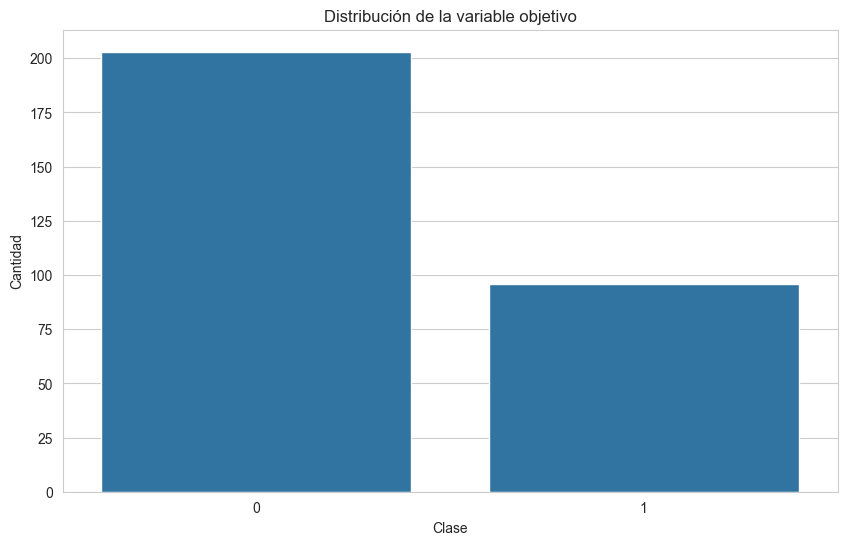

In [14]:
#Vemos la distribucion de la target. Está muy desbalanceado, tener en cuenta esto para las metricas
sns.countplot(x='muerte', data=df)
plt.title("Distribución de la variable objetivo")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

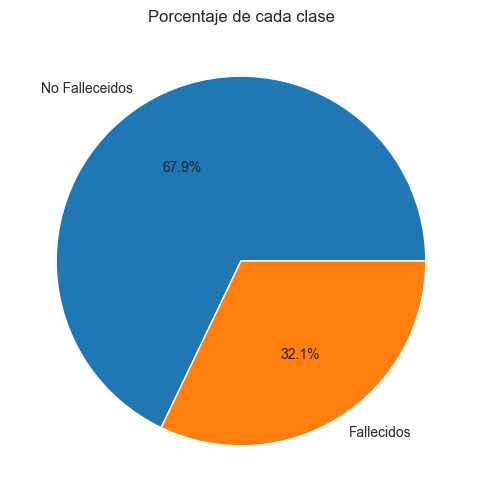

In [16]:
df["muerte"].value_counts().plot.pie(autopct='%1.1f%%', labels=["No Falleceidos", "Fallecidos"])
plt.title("Porcentaje de cada clase")
plt.ylabel("")
plt.show()

In [17]:
df.describe()

,edad,anemia,cpk,diabetes,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,sexo,fumador,dias_seguimiento,muerte
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3468\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3468\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3468\3347895646.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
C:\Users\Usuario\AppData\Local\Tem

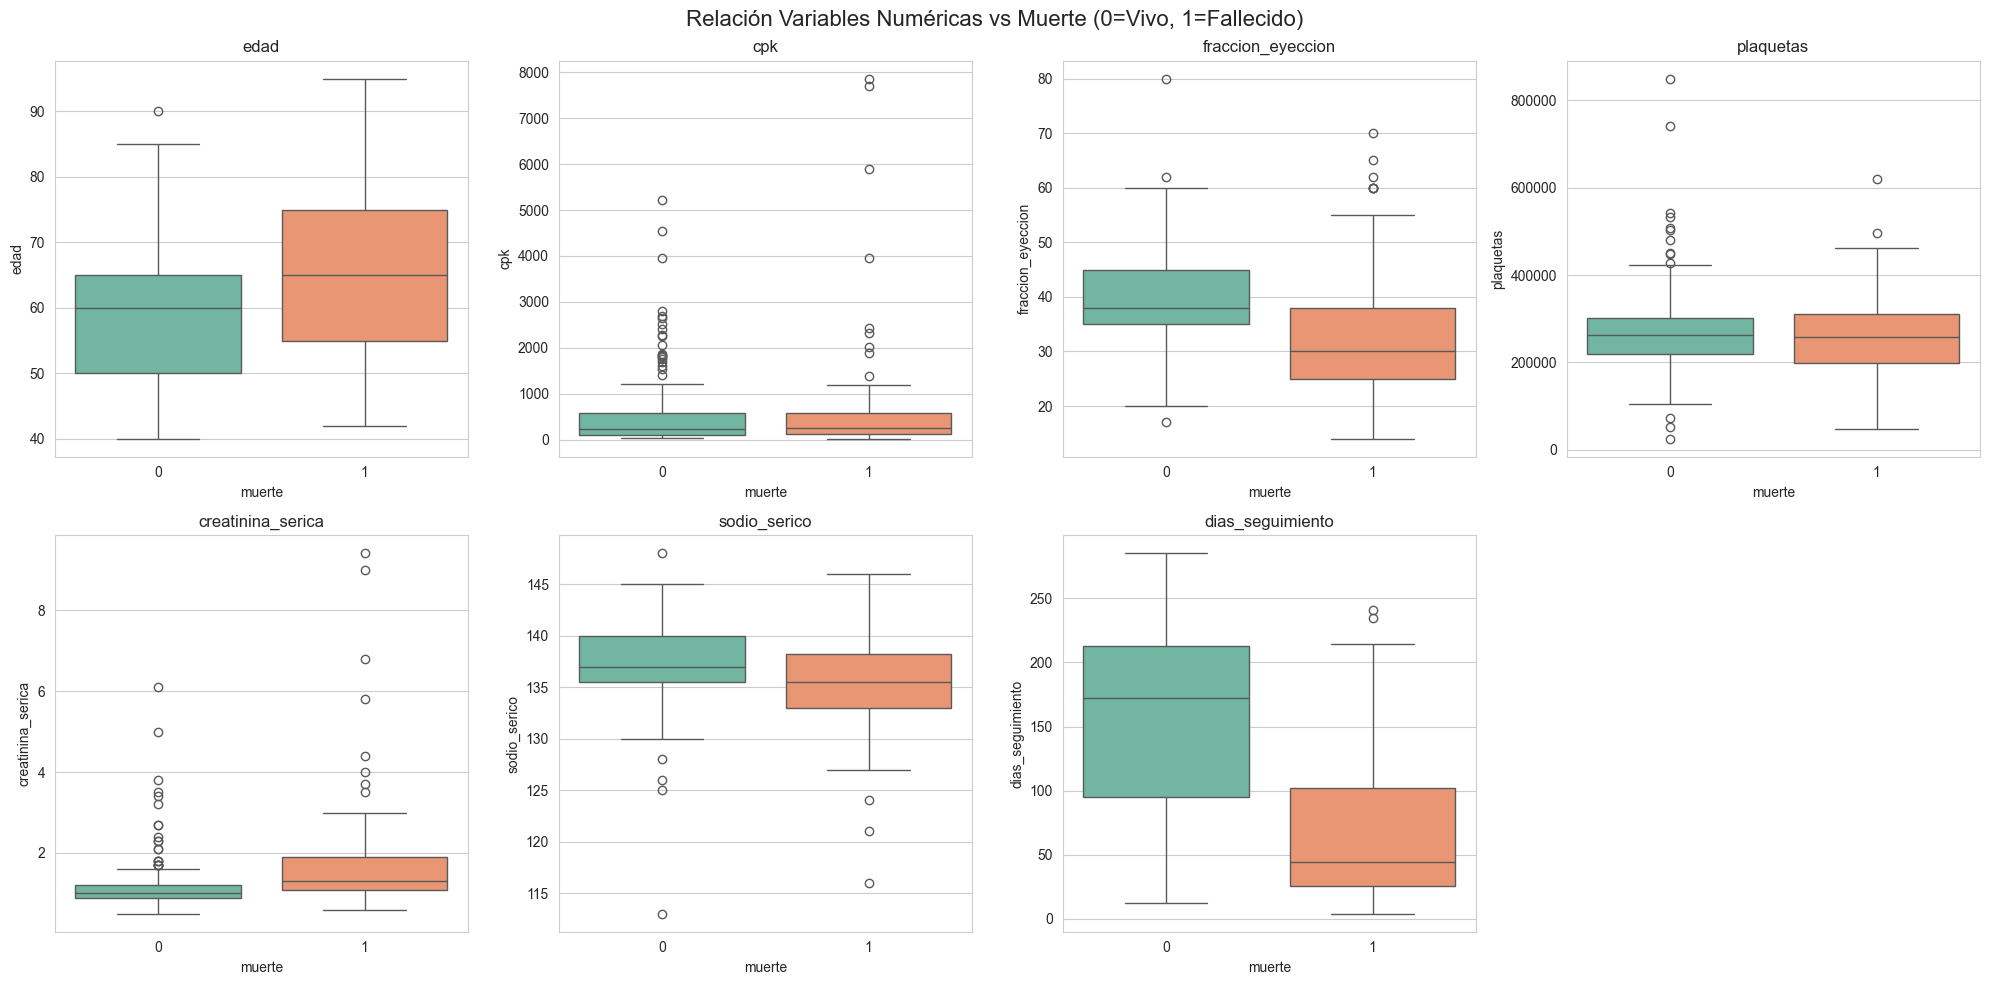

In [21]:
# 1. Separamos las columnas numéricas
num_cols = ['edad', 'cpk', 'fraccion_eyeccion', 'plaquetas', 'creatinina_serica', 'sodio_serico', 'dias_seguimiento']

# 2. Configuración del gráfico (Grid de 2 filas x 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Relación Variables Numéricas vs Muerte (0=Vivo, 1=Fallecido)', fontsize=16)

# Aplanamos el array de ejes para iterar fácil
axes = axes.flatten()

# 3. Bucle para graficar cada una
for i, col in enumerate(num_cols):
    sns.boxplot(x='muerte', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(col)

# Borramos el último gráfico vacío (porque son 7 variables y hay 8 espacios)
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

Se observa que las variables mas importantes para poder predecir fallecimientos son.
Los dias de seguimiento, claramente a menos seguimiento medico el reisgo de muerte aumenta.
La edad, a mayor edad el riesgo de muerte por insuficiencia cardiaca aumenta.
La creatinina, se ve claramente a que alta creatinina puede llevar a una muerte por insuficiencia cardiaca, ya que posiblemente una alta concentracion de creatinina pueda generar un daño renal.


In [ ]:
# Lista de tus variables binarias
binarias = ['anemia', 'diabetes', 'presion_alta', 'sexo', 'fumador']

print("--- ANÁLISIS DE RIESGO POR VARIABLE BINARIA ---")
print("(Qué porcentaje de cada grupo falleció)\n")

for var in binarias:
    # Creamos la tabla cruzada
    # normalize='index' nos da los porcentajes por fila
    crosstab = pd.crosstab(df[var], df['muerte'], normalize='index') * 100
    
    # Imprimimos el resultado
    print(f"Variable: {var.upper()}")
    print(f" - Si es 0 (NO tiene): Falleció el {crosstab.loc[0, 1]:.1f}%")
    print(f" - Si es 1 (SÍ tiene): Falleció el {crosstab.loc[1, 1]:.1f}%")
    
    # Calculamos la diferencia
    diff = crosstab.loc[1, 1] - crosstab.loc[0, 1]
    if abs(diff) < 5:
        print("   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)")
    else:
        print(f"   -> CONCLUSIÓN: ¡Diferencia relevante de {diff:.1f} puntos!")
    print("-" * 40)

--- ANÁLISIS DE RIESGO POR VARIABLE BINARIA ---
(Qué porcentaje de cada grupo falleció)

Variable: ANEMIA
 - Si es 0 (NO tiene): Falleció el 29.4%
 - Si es 1 (SÍ tiene): Falleció el 35.7%
   -> CONCLUSIÓN: ¡Diferencia relevante de 6.2 puntos!
----------------------------------------
Variable: DIABETES
 - Si es 0 (NO tiene): Falleció el 32.2%
 - Si es 1 (SÍ tiene): Falleció el 32.0%
   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)
----------------------------------------
Variable: PRESION_ALTA
 - Si es 0 (NO tiene): Falleció el 29.4%
 - Si es 1 (SÍ tiene): Falleció el 37.1%
   -> CONCLUSIÓN: ¡Diferencia relevante de 7.8 puntos!
----------------------------------------
Variable: SEXO
 - Si es 0 (NO tiene): Falleció el 32.4%
 - Si es 1 (SÍ tiene): Falleció el 32.0%
   -> CONCLUSIÓN: No influye mucho (Diferencia pequeña)
----------------------------------------
Variable: FUMADOR
 - Si es 0 (NO tiene): Falleció el 32.5%
 - Si es 1 (SÍ tiene): Falleció el 31.2%
   -> CONCLUSIÓN: No in

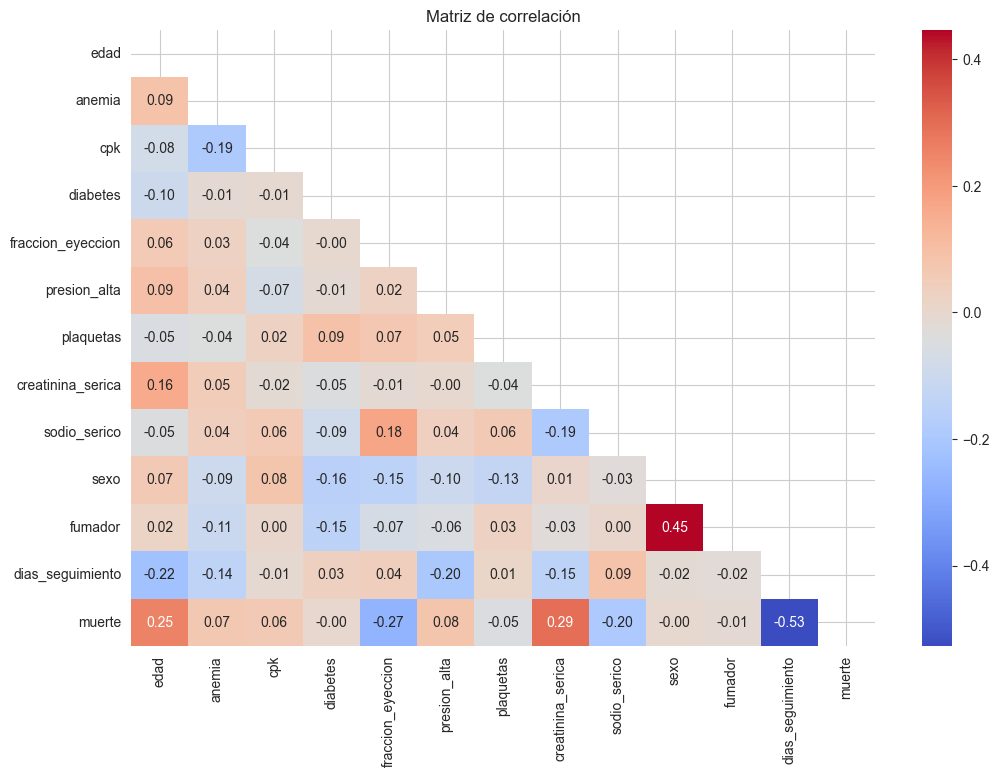

In [ ]:
import numpy as np 

# Solo columnas numéricas (incluyendo type_num)
corr = df.corr()

#Mascara para graficar la mitad
np.ones_like(corr, dtype=bool)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mapa de calor
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Analizando la matriz de coorrelacion vemos nuevamente que las variables que mas relacionadas a la muerte son la edad avanzada, la alta concentracion de creatinina y el menor seguimiento medico de la enfermedad.
De esto vemos que la variable sexo y fumador tienen una alta coorrelacion entre ellas por lo tanto para el entrenamiento del modelo podemos disernir de una o las 2 ya que ninguna tiene correlacion con la target que buscamos.

In [30]:
x = df.drop(['sexo','fumador','diabetes','muerte'], axis = 1).copy()
#Sacamos las variables que no aportan informacion para la clasificacion y sacamos la variable muerte ya que es nuestra target
x

,edad,anemia,cpk,fraccion_eyeccion,presion_alta,plaquetas,creatinina_serica,sodio_serico,dias_seguimiento
0,75.0,0,582,20,1,265000.00,1.9,130,4
1,55.0,0,7861,38,0,263358.03,1.1,136,6
2,65.0,0,146,20,0,162000.00,1.3,129,7
3,50.0,1,111,20,0,210000.00,1.9,137,7
4,65.0,1,160,20,0,327000.00,2.7,116,8
...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,38,1,155000.00,1.1,143,270
295,55.0,0,1820,38,0,270000.00,1.2,139,271
296,45.0,0,2060,60,0,742000.00,0.8,138,278
297,45.0,0,2413,38,0,140000.00,1.4,140,280


In [32]:
y = df['muerte'].copy()
y.value_counts()

muerte
0    203
1     96
Name: count, dtype: int64